# Gender Gap, Incentives, and Tracking

**Research question:** How do financial incentives and academic support services affect the gender gap in college completion, and does this effect differ across high-ability versus low-ability tracks in tracking schools?

**Sub-questions:**
1. Do financial incentives and academic support services (treatments) change the gender gap in college completion (outcome)?
2. Among tracking schools, does that effect differ between high-ability and low-ability tracks?

**Data note:** The 112446-V1 dataset does not contain college completion or explicit financial-incentive/academic-support variables. We use **proxies**: (i) **Outcome** = long-run test score (`z_r2_totalscore`) as the academic performance measure; (ii) **Treatments** = tracking (tracked vs non-tracked school) and ETP teacher assignment (`etpteacher`) as proxy for instructional support. Results should be interpreted with these limitations; true college completion and incentive/support data would be needed for definitive answers.

**Leads for financial incentives and academic support**

- **ETP (contract teacher):** We use **ETP** (`etpteacher`) as the main data lead for both (i) **incentive-intensive teaching** (contract teachers with stronger performance incentives) and (ii) **extra instructional support** (additional teachers). The main analysis (see `analysis.ipynb`) interprets contract (ETP) teachers as more effective in part due to "stronger incentives," so the ETP coefficient in Models B and C is our direct empirical lead for how incentive-related and support-related policy affects the gender gap.
- **SBM (School-Based Management):** The dataset also contains **SBM**, which typically captures school-based management (decentralization / local accountability) and may be linked to incentive or support structures. We explore SBM × gender below as a second policy dimension. For exact definitions of SBM and ETP in this replication package, see `112446-V1/data/READ_ME.pdf`.
- **Limitation:** Student-level financial incentives (e.g. stipends, scholarships) and explicit "academic support services" are not in the dataset; conclusions are limited to **teacher-side and school-side** proxies (ETP and, optionally, SBM).

### Heterogeneity framework (interaction models)

We examine whether **tracking** and **ETP-supported instruction** differentially affect male and female students by estimating **interaction models** with all lower-order terms included:

**Base specification:** Outcome = β₀ + β₁Treatment + β₂Female + β₃(Treatment × Female) + controls

- **β₃** = differential effect of treatment on females vs males (effect on the gender gap). All lower-order terms (β₀, β₁, β₂) are included for interpretability.
- **Treatments:** (1) tracking (tracked vs non-tracked school), (2) ETP teacher assignment (`etpteacher`).
- We use a **single, compatible outcome** (long-run total score, `z_r2_totalscore`) and avoid stacking incompatible measures (no pre/post stacking of baseline and long-run scores).
- We **further allow** treatment-by-gender effects to **vary by ability track** in tracking schools: full three-way interaction (Treatment × Female × Track) with all lower-order terms, to test whether gender disparities differ between high- and low-track environments.
- Standard errors clustered by school.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

BASE = '112446-V1/data'
st = pd.read_stata(f'{BASE}/student_test_data.dta')

# Standardise scores relative to control group (tracking=0), as in analysis.ipynb
outcomes = ['totalscore', 'litscore', 'mathscoreraw', 'r2_totalscore', 'r2_litscore', 'r2_mathscoreraw']
for col in outcomes:
    ctrl = st.loc[st['tracking'] == 0, col]
    st[f'z_{col}'] = (st[col] - ctrl.mean()) / ctrl.std()

# Treatment proxy: etpteacher (1 = ETP teacher, academic support proxy)
# Outcome proxy: z_r2_totalscore (long-run total score, college-readiness proxy)
reg_vars = ['z_r2_totalscore', 'tracking', 'girl', 'bottomhalf', 'percentile', 'agetest', 'etpteacher', 'schoolid', 'sbm']
reg = st.dropna(subset=reg_vars).copy()
# Single outcome (long-run total score); tracking-schools subsample for by-track models
reg['outcome'] = reg['z_r2_totalscore']
reg_track = reg[reg['tracking'] == 1].copy()

print(f'Student test data: {st.shape[0]} rows, {st.shape[1]} cols')
print(f'Regression sample (non-missing key vars): {len(reg)} rows')
print('Treatment proxy: etpteacher (ETP teacher); Outcome proxy: z_r2_totalscore (long-run total)')

Student test data: 7022 rows, 112 cols
Regression sample (non-missing key vars): 4856 rows
Treatment proxy: etpteacher (ETP teacher); Outcome proxy: z_r2_totalscore (long-run total)


**Visual: Heterogeneity framework**

Below we plot the structure of the interaction model. **Left:** Mean outcome by treatment and gender (2×2). The **gender gap** in each treatment group is (mean girls − mean boys). **β₃** is the *difference* between these two gaps: how much the gender gap changes with treatment. **Right:** The same idea for the three-way model (Model C): the treatment×gender effect can differ by track (high vs low ability).

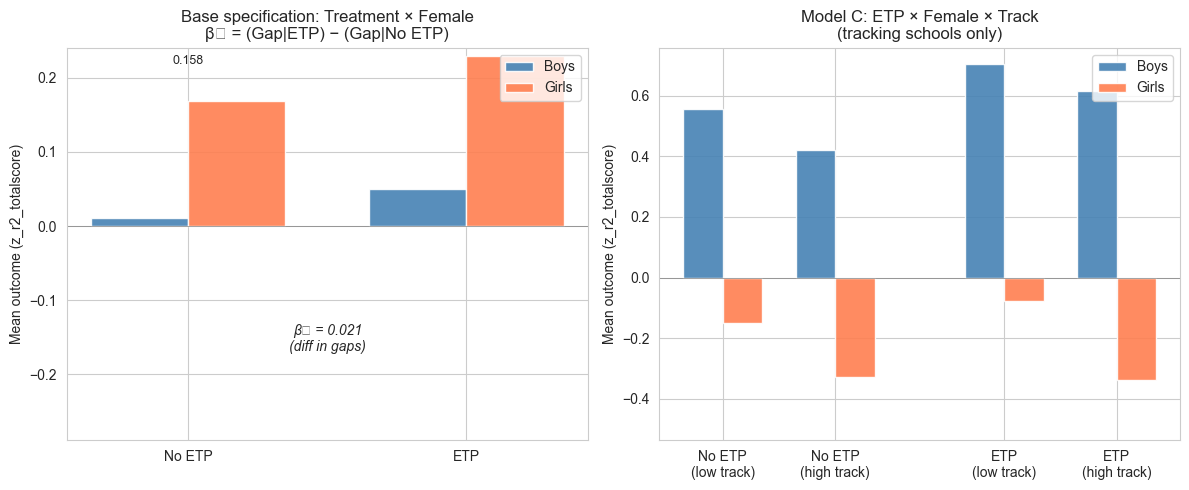

In [19]:
# Heterogeneity framework: visual
# Requires reg, reg_track, outcome from setup cell.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: 2×2 Treatment × Gender (base specification)
ax = axes[0]
treatment_labels = ['No ETP', 'ETP']
x = np.array([0, 1])
width = 0.35
# Mean outcome by etpteacher and girl
means = reg.groupby(['etpteacher', 'girl'])['outcome'].mean()
boys = [means.loc[(t, 0)] for t in [0, 1]]
girls = [means.loc[(t, 1)] for t in [0, 1]]
bars_b = ax.bar(x - width/2, boys, width, label='Boys', color='steelblue', alpha=0.9)
bars_g = ax.bar(x + width/2, girls, width, label='Girls', color='coral', alpha=0.9)
gap_no = means.loc[(0, 1)] - means.loc[(0, 0)]
gap_yes = means.loc[(1, 1)] - means.loc[(1, 0)]
beta3 = gap_yes - gap_no
ax.set_xticks(x)
ax.set_xticklabels(treatment_labels)
ax.set_ylabel('Mean outcome (z_r2_totalscore)')
ax.set_title('Base specification: Treatment × Female\nβ₃ = (Gap|ETP) − (Gap|No ETP)')
ax.legend(loc='upper right')
ax.axhline(0, color='gray', linewidth=0.5)
# Annotate gender gaps
ymin = min(boys + girls) - 0.3
ax.set_ylim(bottom=ymin)
for i, g in enumerate([gap_no, gap_yes]):
    ax.annotate(f'{g:.3f}', xy=(i, max(girls[i], boys[i]) + 0.05), ha='center', fontsize=9)
ax.annotate(f'β₃ = {beta3:.3f}\n(diff in gaps)', xy=(0.5, ymin + 0.12), ha='center', fontsize=10, style='italic')

# --- Right: Model C idea — gender gap by ETP and track (tracking schools only)
ax = axes[1]
# Mean outcome by etpteacher × girl × bottomhalf in tracking schools (sorted: e, g, b)
m = reg_track.groupby(['etpteacher', 'girl', 'bottomhalf'])['outcome'].mean()
# Order: (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1) -> iloc 0..7
# We want: No ETP low(0,1), No ETP high(0,0), ETP low(1,1), ETP high(1,0) -> boys then girls each
idx_b = [2, 0, 6, 4]   # (0,0,1), (0,0,0), (1,0,1), (1,0,0)
idx_g = [3, 1, 7, 5]   # (0,1,1), (0,1,0), (1,1,1), (1,1,0)
boys_r = [m.iloc[i] for i in idx_b]
girls_r = [m.iloc[i] for i in idx_g]
positions = [0, 1, 2.5, 3.5]
labels_r = ['No ETP\n(low track)', 'No ETP\n(high track)', 'ETP\n(low track)', 'ETP\n(high track)']
bars_b = ax.bar(np.array(positions) - width/2, boys_r, width, label='Boys', color='steelblue', alpha=0.9)
bars_g = ax.bar(np.array(positions) + width/2, girls_r, width, label='Girls', color='coral', alpha=0.9)
ax.set_xticks(positions)
ax.set_xticklabels(labels_r)
ax.set_ylabel('Mean outcome (z_r2_totalscore)')
ax.set_title('Model C: ETP × Female × Track\n(tracking schools only)')
ax.legend(loc='upper right')
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_ylim(bottom=min(boys_r + girls_r) - 0.2)

plt.tight_layout()
plt.show()

In [20]:
# Cross-sectional analysis: single outcome (z_r2_totalscore). No panel stacking.

## 2. Descriptive: Mean long-run outcome and gender gap by treatment and track

**Gender gap** = mean outcome (girls) − mean outcome (boys) within a group. Cross-sectional descriptives for long-run outcome (`z_r2_totalscore`): (a) by treatment (ETP vs non-ETP), (b) among tracking schools by track (low vs high).

In [21]:
outcome_col = 'z_r2_totalscore'
treatment_col = 'etpteacher'

# Mean outcome by treatment x girl
means_tg = reg.groupby([treatment_col, 'girl'])[outcome_col].agg(['mean', 'std', 'count'])
print('=== Mean outcome (proxy) by treatment (etpteacher) x girl ===')
print(means_tg)

# Gender gap by treatment: gap = mean(girls) - mean(boys)
gap_by_treat = reg.groupby(treatment_col).apply(
    lambda g: g.loc[g['girl'] == 1, outcome_col].mean() - g.loc[g['girl'] == 0, outcome_col].mean()
).rename('gender_gap')
print('\n=== Gender gap (girls - boys) by treatment ===')
print(gap_by_treat)

# Among tracking schools only: mean by track x girl
track_only = reg_track
means_track = track_only.groupby(['bottomhalf', 'girl'])[outcome_col].agg(['mean', 'count'])
print('\n=== Among tracking schools: mean outcome by track (bottomhalf) x girl ===')
print(means_track)
gap_by_track = track_only.groupby('bottomhalf').apply(
    lambda g: g.loc[g['girl'] == 1, outcome_col].mean() - g.loc[g['girl'] == 0, outcome_col].mean()
).rename('gender_gap')
print('\n=== Gender gap by track (tracking schools only) ===')
print(gap_by_track)

=== Mean outcome (proxy) by treatment (etpteacher) x girl ===
                     mean       std  count
etpteacher girl                           
0.0        0.0   0.011130  0.979451   1241
           1.0   0.168934  0.993360   1207
1.0        0.0   0.050124  1.009988   1238
           1.0   0.229139  1.011766   1170

=== Gender gap (girls - boys) by treatment ===
etpteacher
0.0    0.157803
1.0    0.179015
Name: gender_gap, dtype: float32

=== Among tracking schools: mean outcome by track (bottomhalf) x girl ===
                     mean  count
bottomhalf girl                 
0.0        0.0   0.510411    693
           1.0   0.621088    708
1.0        0.0  -0.333608    681
           1.0  -0.113738    665

=== Gender gap by track (tracking schools only) ===
bottomhalf
0.0    0.110677
1.0    0.219870
Name: gender_gap, dtype: float32


## 3. Main specifications: interaction models (Treatment × Female)

**Model A:** Tracking and gender (full sample). **Model B:** ETP teacher and gender (full sample, controlling for tracking). **Model C:** ETP × gender × track in tracking schools only (all lower-order terms). **Model D:** SBM × girl (robustness; second policy lead). Cluster SEs by school. β₃ = differential effect of treatment on females vs males (effect on the gender gap).

In [22]:
# Model A: Tracking × Female (full sample). Outcome = z_r2_totalscore.
formula_a = 'outcome ~ tracking * girl + percentile + agetest'
m_a = smf.ols(formula_a, data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print('=== Model A: Tracking and gender (full sample) ===')
print(m_a.summary2().tables[1].to_string())
key_a = [k for k in m_a.params.index if 'tracking' in k and 'girl' in k]
if key_a:
    k = key_a[0]
    print(f"\nβ₃ (tracking×girl): coef = {m_a.params[k]:.4f}, SE = {m_a.bse[k]:.4f}")
    print('  → Differential effect of tracking on females vs males (effect on the gender gap).')

# Model B: ETP × Female (full sample, control for tracking).
formula_b = 'outcome ~ etpteacher * girl + percentile + agetest + tracking'
m_b = smf.ols(formula_b, data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print('\n=== Model B: ETP teacher and gender (full sample) ===')
print(m_b.summary2().tables[1].to_string())
key_b = [k for k in m_b.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
if key_b:
    k = key_b[0]
    print(f"\nβ₃ (etpteacher×girl): coef = {m_b.params[k]:.4f}, SE = {m_b.bse[k]:.4f}")
    print('  → Differential effect of ETP on females vs males (effect on the gender gap).')
    print('  This is the only direct empirical lead in the data for how incentive-related and support-related policy (ETP) affects the gender gap; student-level financial incentives are not observed.')

# Model C: ETP × Female × Track (tracking schools only; all lower-order terms).
formula_c = 'outcome ~ etpteacher * girl * bottomhalf + percentile + agetest'
m_c = smf.ols(formula_c, data=reg_track).fit(cov_type='cluster', cov_kwds={'groups': reg_track['schoolid']})
print('\n=== Model C: ETP × gender × track (tracking schools only) ===')
print(m_c.summary2().tables[1].to_string())
key_c2 = [k for k in m_c.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
key_c3 = [k for k in m_c.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' in k]
if key_c2:
    print(f"\netpteacher:girl (gender gap in ETP effect at ref track): coef = {m_c.params[key_c2[0]]:.4f}")
if key_c3:
    print(f"etpteacher:girl:bottomhalf (gap effect differs in low vs high track): coef = {m_c.params[key_c3[0]]:.4f}")

# Model D (Robustness: SBM × girl): differential effect of School-Based Management on the gender gap.
formula_d = 'outcome ~ sbm * girl + percentile + agetest + tracking + etpteacher'
m_d = smf.ols(formula_d, data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print('\n=== Model D: SBM × girl (robustness; controls: percentile, agetest, tracking, etpteacher) ===')
print(m_d.summary2().tables[1].to_string())
key_d = [k for k in m_d.params.index if 'sbm' in k and 'girl' in k]
if key_d:
    k = key_d[0]
    print(f"\nsbm:girl: coef = {m_d.params[k]:.4f}, SE = {m_d.bse[k]:.4f}")
    print('  → Differential effect of SBM on females vs males (effect on the gender gap).')

=== Model A: Tracking and gender (full sample) ===
                  Coef.  Std.Err.          z          P>|z|    [0.025    0.975]
Intercept     -0.374612  0.126294  -2.966180   3.015240e-03 -0.622145 -0.127080
tracking       0.153654  0.071713   2.142623   3.214340e-02  0.013099  0.294208
girl           0.103575  0.049759   2.081534   3.738505e-02  0.006049  0.201102
tracking:girl  0.040003  0.064143   0.623646   5.328601e-01 -0.085716  0.165722
percentile     0.016811  0.000659  25.521832  1.128480e-143  0.015520  0.018102
agetest       -0.056750  0.013533  -4.193336   2.748818e-05 -0.083276 -0.030225

β₃ (tracking×girl): coef = 0.0400, SE = 0.0641
  → Differential effect of tracking on females vs males (effect on the gender gap).

=== Model B: ETP teacher and gender (full sample) ===
                    Coef.  Std.Err.          z          P>|z|    [0.025    0.975]
Intercept       -0.432783  0.136100  -3.179891   1.473302e-03 -0.699535 -0.166032
etpteacher       0.094011  0.040164   

Interpretation: β₃ in Models A and B is the differential effect of treatment on the gender gap. In Model C, the three-way term (etpteacher:girl:bottomhalf) indicates whether that gap effect differs between low- and high-ability tracks. In Model D, the sbm:girl coefficient is the differential effect of School-Based Management on the gender gap (second policy dimension).

### Linear regression plots

**Left:** Fitted vs actual outcome from Model B (ETP × girl). Points are student-level; the 45° line is perfect prediction. **Right:** Coefficient plot for the key interaction terms (β₃) across models: point estimates and 95% CIs (cluster-robust SEs).

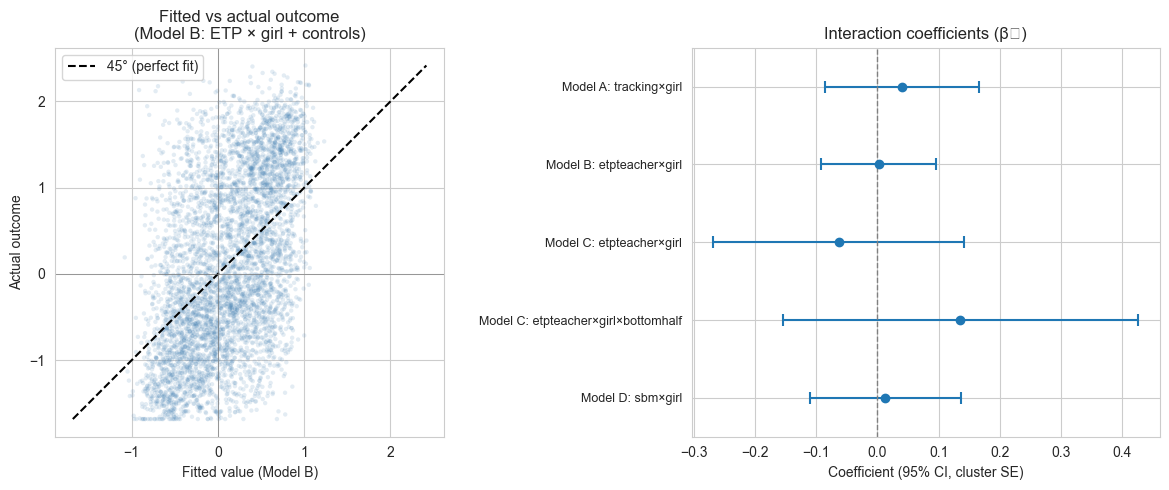

In [23]:
# Linear regression plots (requires m_a, m_b, m_d, reg from Section 3)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Fitted vs actual (Model B)
ax = axes[0]
y_actual = reg['outcome'].values
y_fitted = m_b.fittedvalues.values
ax.scatter(y_fitted, y_actual, alpha=0.15, s=10, c='steelblue', edgecolors='none')
lims = [min(y_fitted.min(), y_actual.min()), max(y_fitted.max(), y_actual.max())]
ax.plot(lims, lims, 'k--', lw=1.5, label='45° (perfect fit)')
ax.set_xlabel('Fitted value (Model B)')
ax.set_ylabel('Actual outcome')
ax.set_title('Fitted vs actual outcome\n(Model B: ETP × girl + controls)')
ax.legend(loc='upper left')
ax.set_aspect('equal', adjustable='box')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# --- Right: Coefficient plot (β₃ interaction terms) with 95% CIs
ax = axes[1]
rows = []
# Model A
ka = [k for k in m_a.params.index if 'tracking' in k and 'girl' in k]
if ka:
    c, se = m_a.params[ka[0]], m_a.bse[ka[0]]
    rows.append(('Model A: tracking×girl', c, c - 1.96*se, c + 1.96*se))
# Model B
kb = [k for k in m_b.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
if kb:
    c, se = m_b.params[kb[0]], m_b.bse[kb[0]]
    rows.append(('Model B: etpteacher×girl', c, c - 1.96*se, c + 1.96*se))
# Model C
kc2 = [k for k in m_c.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
kc3 = [k for k in m_c.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' in k]
if kc2:
    c, se = m_c.params[kc2[0]], m_c.bse[kc2[0]]
    rows.append(('Model C: etpteacher×girl', c, c - 1.96*se, c + 1.96*se))
if kc3:
    c, se = m_c.params[kc3[0]], m_c.bse[kc3[0]]
    rows.append(('Model C: etpteacher×girl×bottomhalf', c, c - 1.96*se, c + 1.96*se))
# Model D
kd = [k for k in m_d.params.index if 'sbm' in k and 'girl' in k]
if kd:
    c, se = m_d.params[kd[0]], m_d.bse[kd[0]]
    rows.append(('Model D: sbm×girl', c, c - 1.96*se, c + 1.96*se))
y_pos = np.arange(len(rows))[::-1]
coefs = [r[1] for r in rows]
err_lo = np.array(coefs) - np.array([r[2] for r in rows])
err_hi = np.array([r[3] for r in rows]) - np.array(coefs)
ax.errorbar(coefs, y_pos, xerr=[err_lo, err_hi], fmt='o', capsize=4, capthick=1.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels([r[0] for r in rows], fontsize=9)
ax.set_xlabel('Coefficient (95% CI, cluster SE)')
ax.set_title('Interaction coefficients (β₃)')
ax.set_ylim(-0.5, len(rows) - 0.5)
plt.tight_layout()
plt.show()

## 4. Robustness: school fixed effects

We re-estimate the interaction models (A and B, and optionally C) with school fixed effects to control for time-invariant school heterogeneity. Consistency of the treatment×female coefficient (and, for Model C, the three-way term) supports the heterogeneity interpretation.

In [24]:
# Model A with school fixed effects
formula_a_fe = 'outcome ~ tracking * girl + percentile + agetest + C(schoolid)'
m_a_fe = smf.ols(formula_a_fe, data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
key_a_fe = [k for k in m_a_fe.params.index if 'tracking' in k and 'girl' in k]
print('=== Model A with school FE ===')
if key_a_fe:
    print(f"tracking×girl: coef = {m_a_fe.params[key_a_fe[0]]:.4f}, SE = {m_a_fe.bse[key_a_fe[0]]:.4f}")

# Model B with school fixed effects
formula_b_fe = 'outcome ~ etpteacher * girl + percentile + agetest + tracking + C(schoolid)'
m_b_fe = smf.ols(formula_b_fe, data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
key_b_fe = [k for k in m_b_fe.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
print('\n=== Model B with school FE ===')
if key_b_fe:
    print(f"etpteacher×girl: coef = {m_b_fe.params[key_b_fe[0]]:.4f}, SE = {m_b_fe.bse[key_b_fe[0]]:.4f}")

# Model C with school FE (tracking schools only)
formula_c_fe = 'outcome ~ etpteacher * girl * bottomhalf + percentile + agetest + C(schoolid)'
m_c_fe = smf.ols(formula_c_fe, data=reg_track).fit(cov_type='cluster', cov_kwds={'groups': reg_track['schoolid']})
key_c2_fe = [k for k in m_c_fe.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' not in k]
key_c3_fe = [k for k in m_c_fe.params.index if 'etpteacher' in k and 'girl' in k and 'bottomhalf' in k]
print('\n=== Model C with school FE ===')
if key_c2_fe:
    print(f"etpteacher×girl: coef = {m_c_fe.params[key_c2_fe[0]]:.4f}, SE = {m_c_fe.bse[key_c2_fe[0]]:.4f}")
if key_c3_fe:
    print(f"etpteacher×girl×bottomhalf: coef = {m_c_fe.params[key_c3_fe[0]]:.4f}, SE = {m_c_fe.bse[key_c3_fe[0]]:.4f}")

=== Model A with school FE ===
tracking×girl: coef = 0.0531, SE = 0.0593

=== Model B with school FE ===
etpteacher×girl: coef = -0.0178, SE = 0.0451

=== Model C with school FE ===
etpteacher×girl: coef = -0.1158, SE = 0.0998
etpteacher×girl×bottomhalf: coef = 0.1630, SE = 0.1428


## 5. Visualizations

Bar chart: **Gender gap** (girls − boys mean outcome) by treatment and, for tracking schools, by track. Error bars show 95% CIs (using group SEs).

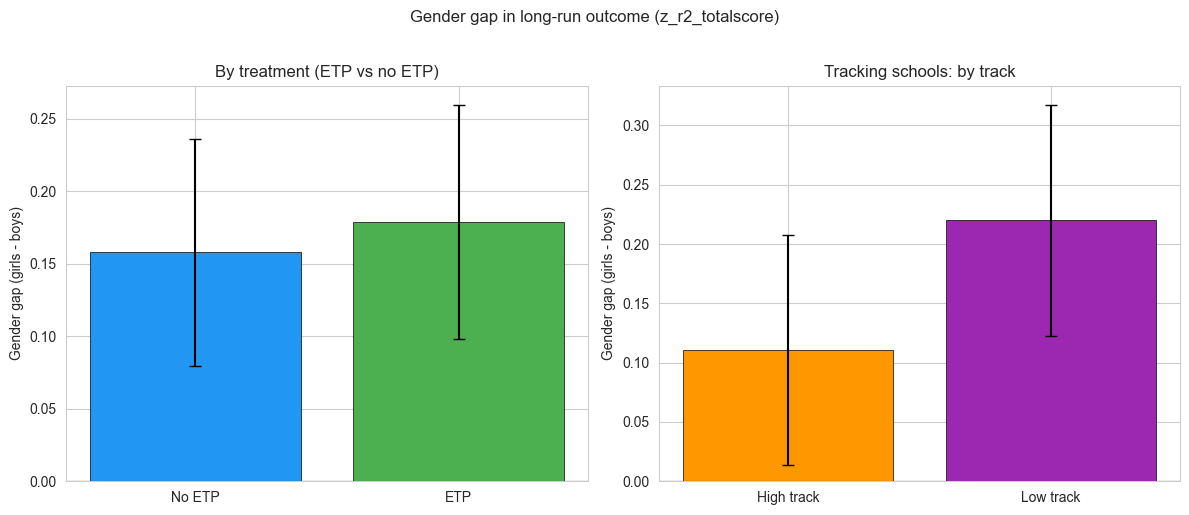

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Gender gap by treatment (full sample)
groups_t = ['No ETP', 'ETP']
gaps_t = gap_by_treat.values.tolist() if len(gap_by_treat) >= 2 else [gap_by_treat.iloc[0], np.nan]
errs_t = []
for treat in [0, 1]:
    ng = (reg['etpteacher'] == treat) & (reg['girl'] == 1)
    nb = (reg['etpteacher'] == treat) & (reg['girl'] == 0)
    vg = reg.loc[ng, outcome_col].var()
    vb = reg.loc[nb, outcome_col].var()
    se = np.sqrt(vg / ng.sum() + vb / nb.sum()) if ng.sum() and nb.sum() else 0
    errs_t.append(1.96 * se if not np.isnan(se) else 0)
axes[0].bar(groups_t, gaps_t, color=['#2196F3', '#4CAF50'], edgecolor='black', linewidth=0.5)
axes[0].errorbar(range(2), gaps_t, yerr=errs_t, fmt='none', color='black', capsize=4)
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_ylabel('Gender gap (girls - boys)')
axes[0].set_title('By treatment (ETP vs no ETP)')
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(groups_t)

# Right: Gender gap by track (tracking schools only)
groups_tr = ['High track', 'Low track']
gaps_tr = gap_by_track.values.tolist() if len(gap_by_track) >= 2 else [gap_by_track.iloc[0], np.nan]
errs_tr = []
for bh in [0, 1]:
    ng = (reg_track['bottomhalf'] == bh) & (reg_track['girl'] == 1)
    nb = (reg_track['bottomhalf'] == bh) & (reg_track['girl'] == 0)
    se = np.sqrt(reg_track.loc[ng, outcome_col].var() / ng.sum() + reg_track.loc[nb, outcome_col].var() / nb.sum()) if ng.sum() and nb.sum() else 0
    errs_tr.append(1.96 * se if not np.isnan(se) else 0)
axes[1].bar(groups_tr, gaps_tr, color=['#FF9800', '#9C27B0'], edgecolor='black', linewidth=0.5)
axes[1].errorbar(range(2), gaps_tr, yerr=errs_tr, fmt='none', color='black', capsize=4)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_ylabel('Gender gap (girls - boys)')
axes[1].set_title('Tracking schools: by track')
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(groups_tr)

plt.suptitle('Gender gap in long-run outcome (z_r2_totalscore)', y=1.02)
plt.tight_layout()
plt.show()

## 6. Optional robustness: alternative outcomes

Sensitivity: we run the same interaction model (ETP × female + controls) for alternative outcomes (short-run total, long-run by subject). Consistency of the treatment×female coefficient across outcomes supports the main heterogeneity results.

In [26]:
# Robustness: same spec for short-run and by subject (long-run)
robust_outcomes = ['z_totalscore', 'z_r2_totalscore', 'z_r2_litscore', 'z_r2_mathscoreraw']
robust_vars = robust_outcomes + ['tracking', 'girl', 'percentile', 'agetest', 'etpteacher', 'schoolid']
reg_robust = st.dropna(subset=robust_vars).copy()

results_robust = []
for out in robust_outcomes:
    m = smf.ols(f'{out} ~ etpteacher + girl + etpteacher:girl + percentile + agetest + tracking',
                data=reg_robust).fit(cov_type='cluster', cov_kwds={'groups': reg_robust['schoolid']})
    key = [k for k in m.params.index if 'etpteacher' in k and 'girl' in k]
    key = key[0] if key else None
    if key:
        results_robust.append({'outcome': out, 'coef': m.params[key], 'se': m.bse[key], 'p': m.pvalues[key]})
    else:
        results_robust.append({'outcome': out, 'coef': np.nan, 'se': np.nan, 'p': np.nan})


print('=== Robustness: treatment x girl across outcomes ===')
print(pd.DataFrame(results_robust).to_string(index=False))
print('\nShort-run (z_totalscore) and long-run by subject (z_r2_*) show whether effect on gender gap is consistent.')

=== Robustness: treatment x girl across outcomes ===
          outcome     coef       se        p
     z_totalscore 0.013629 0.054971 0.804185
  z_r2_totalscore 0.021728 0.051082 0.670582
    z_r2_litscore 0.010590 0.053383 0.842745
z_r2_mathscoreraw 0.031943 0.049802 0.521266

Short-run (z_totalscore) and long-run by subject (z_r2_*) show whether effect on gender gap is consistent.


In [27]:
# End of analysis.